In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

### K-Means Cluster Analysis of Profitability

In [5]:
parcel_points_gdf = gpd.read_file('./data/NYS_Tax_Parcels_Public_Points_2022.geojson')

In [142]:
financial_df = pd.read_csv('./data/Financial Characteristics (ACSST5Y2022.S2503)/ACSST5Y2022.S2503-Data.csv')
shortage_tracts_gdf = gpd.read_file('./data/shortage_tracts_gdf_1pcp220.geojson')
financial_df = financial_df.iloc[1:, :]

# Filter unserved columns and Add unserved density columns
shortage_tracts_gdf = shortage_tracts_gdf[(shortage_tracts_gdf['unserved_medicaid'] > 0) | (shortage_tracts_gdf['unserved_commercial'] > 0)]
shortage_tracts_gdf['unserved medicaid enrollees per km2'] = (shortage_tracts_gdf['unserved_medicaid'] / shortage_tracts_gdf['ALAND'] * 1000000).round(1)
shortage_tracts_gdf['unserved commercial insurance enrollees per km2'] = (shortage_tracts_gdf['unserved_commercial'] / shortage_tracts_gdf['ALAND'] * 1000000).round(1)
shortage_tracts_gdf['insured population per km2'] = ((shortage_tracts_gdf['medicaid'] + shortage_tracts_gdf['commercial']) / shortage_tracts_gdf['ALAND'] * 1000000).round(1)

columns_to_keep = ['GEOID', 'geometry', 'insured population per km2', 'unserved medicaid enrollees per km2', 'unserved commercial insurance enrollees per km2']
shortage_tracts_gdf = shortage_tracts_gdf[columns_to_keep]
shortage_tracts_gdf['GEOID'] = shortage_tracts_gdf['GEOID'].astype('string')

C:\Users\kl3539\AppData\Local\Temp\ipykernel_28452\1220218655.py:1: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,278,279,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449

(3533, 13)
(1171, 16)


In [133]:
income_df = financial_df[['GEO_ID', 'S2503_C01_013E', 'S2503_C01_024E']]
income_df.rename(columns={'S2503_C01_013E': 'Median household income', 'S2503_C01_024E': 'Median monthly housing cost'}, inplace=True)
income_df['Median household income'] = pd.to_numeric(income_df['Median household income'], errors='coerce')
income_df['Median monthly housing cost'] = pd.to_numeric(income_df['Median monthly housing cost'], errors='coerce')
income_df = income_df.dropna()
income_df['Median household disposable income'] = income_df['Median household income'] - income_df['Median monthly housing cost'] * 12
income_df['GEO_ID'] = income_df['GEO_ID'].str.slice(-11)

print(income_df)

           GEO_ID  Median household income  Median monthly housing cost  \
1     36001000100                  44547.0                        985.0   
2     36001000201                  33688.0                        983.0   
3     36001000202                  32585.0                        674.0   
4     36001000301                  43214.0                       1121.0   
5     36001000302                  50875.0                       1357.0   
...           ...                      ...                          ...   
5407  36123150301                  71713.0                        951.0   
5408  36123150302                  47122.0                       1014.0   
5409  36123150400                  81038.0                        985.0   
5410  36123150501                  61123.0                        749.0   
5411  36123150502                  70179.0                        907.0   

      Median household disposable income  
1                                32727.0  
2            

C:\Users\kl3539\AppData\Local\Temp\ipykernel_28452\2187871009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df.rename(columns={'S2503_C01_013E': 'Median household income', 'S2503_C01_024E': 'Median monthly housing cost'}, inplace=True)
C:\Users\kl3539\AppData\Local\Temp\ipykernel_28452\2187871009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['Median household income'] = pd.to_numeric(income_df['Median household income'], errors='coerce')
C:\Users\kl3539\AppData\Local\Temp\ipykernel_28452\2187871009.py:4: SettingWithCopyWarning: 
A val

In [134]:
# Join datasets for clustering analysis
merged_gdf = shortage_tracts_gdf.merge(income_df, how='left', left_on='GEOID', right_on='GEO_ID')

merged_gdf = merged_gdf[[
    'GEOID', 'geometry',
    'unserved medicaid enrollees per km2',
    'unserved commercial insurance enrollees per km2', 
    'insured population per km2',
    'Median household income', 'Median household disposable income'
]]

In [135]:
# Perform the spatial join
joined_gdf = gpd.sjoin(parcel_points_gdf, merged_gdf, how="inner", predicate='within')

# Calculate the average land price per sqft for each polygon
avg_land_price = joined_gdf.groupby('GEOID')['land_price_per_sqft(dollars)'].mean().reset_index(name='avg_land_price_per_sqft').round(2)

# Merge the average land price back into merged_gdf
joined_gdf = merged_gdf.merge(avg_land_price, left_on='GEOID', right_on='GEOID')
joined_gdf = joined_gdf.dropna()

# Remove outliers in your GeoDataFrame with numeric features
Q1 = joined_gdf['avg_land_price_per_sqft'].quantile(0.25)
Q3 = joined_gdf['avg_land_price_per_sqft'].quantile(0.75)
IQR = Q3 - Q1
multiplier = 5

# Filter out outliers
joined_gdf = joined_gdf[~((joined_gdf['avg_land_price_per_sqft'] < (Q1 - multiplier * IQR)) | (joined_gdf['avg_land_price_per_sqft'] > (Q3 + multiplier * IQR)))]

In [136]:
# Select features for K-means clustering
cluster_df = joined_gdf[[
    'unserved medicaid enrollees per km2',
    'unserved commercial insurance enrollees per km2', 
    'insured population per km2',
    'Median household income', 'Median household disposable income',
    'avg_land_price_per_sqft']]

display(cluster_df)

,unserved medicaid enrollees per km2,unserved commercial insurance enrollees per km2,insured population per km2,Median household income,Median household disposable income,avg_land_price_per_sqft
0,0.0,21.9,23.6,92083.0,79375.0,0.17
1,0.0,12.0,18.2,73714.0,61666.0,0.22
2,0.0,12.3,36.4,78750.0,67542.0,0.29
3,4.7,0.0,318.8,58971.0,48123.0,1.12
4,2.5,2.2,14.6,62852.0,52136.0,0.21
...,...,...,...,...,...,...
1166,3238.1,0.0,3977.1,31765.0,22705.0,1.92
1167,3.1,46.2,53.3,96154.0,77842.0,0.03
1168,2319.4,0.0,3198.7,19948.0,9988.0,0.70
1169,20.5,0.0,184.5,76941.0,62961.0,1.48


In [137]:
# Scale our features data to range between 0 and 1
# To do so we use the MinMaxScaler
# Note that this outputs a numpy array
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Transform the data
X = scaler.fit_transform(cluster_df)
print(type(X))
display(pd.DataFrame(X,columns=cluster_df.columns))

<class 'numpy.ndarray'>


,unserved medicaid enrollees per km2,unserved commercial insurance enrollees per km2,insured population per km2,Median household income,Median household disposable income,avg_land_price_per_sqft
0,0.000000,0.001729,0.000178,0.339276,0.395336,0.004958
1,0.000000,0.000947,0.000107,0.256682,0.310371,0.006416
2,0.000000,0.000971,0.000346,0.279326,0.338563,0.008457
3,0.000103,0.000000,0.004042,0.190391,0.245394,0.032663
4,0.000055,0.000174,0.000060,0.207842,0.264648,0.006124
...,...,...,...,...,...,...
1136,0.070994,0.000000,0.051925,0.068062,0.123443,0.055993
1137,0.000068,0.003648,0.000567,0.357581,0.387981,0.000875
1138,0.050852,0.000000,0.041736,0.014928,0.062429,0.020414
1139,0.000449,0.000000,0.002284,0.271192,0.316584,0.043161


C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:13

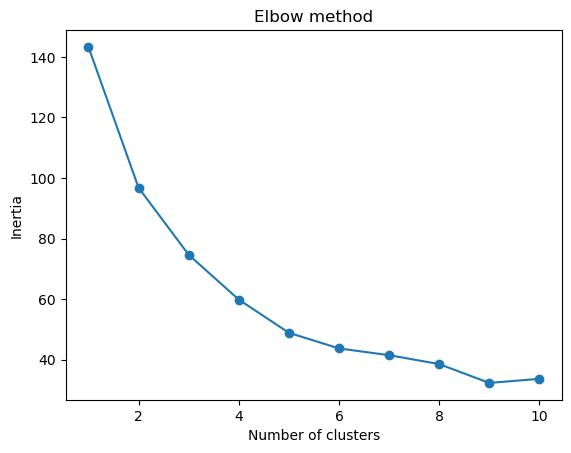

In [138]:
# Apply the elbow method to consider appropriate cluster size
from sklearn.cluster import KMeans
inertias = []
for i in range(1,11):
    kmeans_elbow = KMeans(n_clusters=i, n_init="auto")
    kmeans_elbow.fit(X)
    inertias.append(kmeans_elbow.inertia_)
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [139]:
# Conduct the K-means analysis
# First defining a variable to control number of k categories
n_k = 4
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=n_k, random_state=0, n_init="auto").fit(X)
# Display out cluster center means
display(pd.DataFrame(np.round(kmeans_model.cluster_centers_, decimals=4),columns=cluster_df.columns))

C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,unserved medicaid enrollees per km2,unserved commercial insurance enrollees per km2,insured population per km2,Median household income,Median household disposable income,avg_land_price_per_sqft
0,0.0159,0.0131,0.0357,0.2375,0.2707,0.0638
1,0.0520,0.4680,0.1430,0.3278,0.3309,0.1807
2,0.4055,0.0058,0.4878,0.1394,0.1587,0.4739
3,0.0134,0.0240,0.0511,0.4860,0.4894,0.0974
4,0.1140,0.0100,0.2240,0.2203,0.2307,0.3010


C:\Users\kl3539\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


[0 0 0 ... 0 0 4]


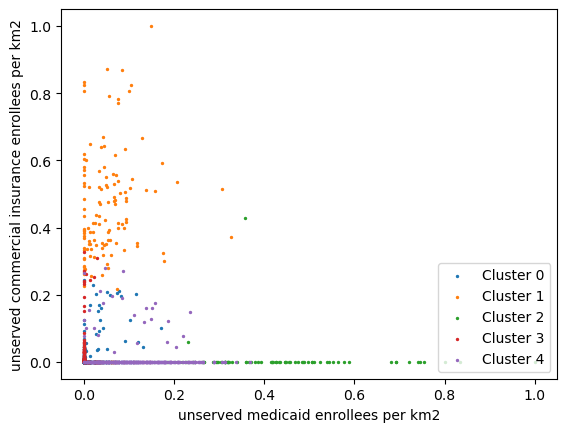

In [140]:
# Predict and visualize the clusters using pairs of features
# First make the predictions 
y_label = kmeans_model.fit_predict(X)
print(y_label)

# Then do some  looping to plot clusters for pairs of features 
columnx = 0
columny = 1
for i in range(0,n_k):
    plt.scatter(X[y_label==i, columnx], X[y_label==i, columny], s=2, label ='Cluster '+str(i))

plt.xlabel(cluster_df.columns[columnx])
plt.ylabel(cluster_df.columns[columny])
plt.legend(loc="lower right")
plt.show()

Cluster 0 - "Emerging Markets, Low Cost": Low density of unserved populations and the lowest land prices suggest a lower cost of entry, making it an emerging market for healthcare services. Profitability may be moderate due to lower income levels.

Cluster 1 - "High Commercial Demand, Profitable market": The high density of unserved commercial insurance enrollees, coupled with moderate land prices and higher income levels, indicates a potentially high-demand area but with competition and higher operational costs. Profitability is likely but requires competitive differentiation.

Cluster 2 - "High Medicaid Demand, High Cost": The highest density of both insured population and unserved Medicaid enrollees, combined with the highest land prices and lowest income, suggests a market with high service demand. Profitability could be significant, particularly with Medicaid or low-income focused services, despite higher initial investments.

Cluster 3 - "Affluent Niche": The combination of the highest income levels, moderate coverage, and moderate land prices positions this cluster as an affluent niche market. High profitability can be expected from premium healthcare services catering to high-income individuals.

Cluster 4 - "Moderate Demand, High Cost": Moderate population densities, unserved rates, and high land prices indicate a balanced opportunity for profitability in both volume and value. Suitable for a range of healthcare services with a focus on quality to attract a mid to high-income population.

In [141]:
# Get cluster center means and export it for ChatGPT to label them.
cluster_centers_profitability = pd.DataFrame(np.round(kmeans_model.cluster_centers_, decimals=4),columns=cluster_df.columns)
cluster_centers_profitability.to_csv('cluster_centers_profitability.csv', index=False)

#Add cluster assignments to the original DataFrame and export it
joined_gdf['cluster_health_profiltability'] = kmeans_model.labels_
joined_gdf.to_file('cluster_health_profiltability.geojson', driver='GeoJSON')